<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary 
##### **Context**: As smartphones have become more accessible across the world, social media outlets, such as Twitter, have become important means of communicating during times of an emergency. As a result, more organizations are interested in tracking conversations in this space to respond more quickly.

**Problem**: However, a user's intent in a tweet isn't always clear. Words, such as "ablaze", can be used in multiple contexts. It can be descriptive of a sunset or it could be indicative of something more serious, like a forest fire. 

##### **Approach**: For this project, we will use a data set of twitter posts, found on [Kaggle](https://www.kaggle.com/c/nlp-getting-started). The goal is to identify an algorithm that most accuractely classifies a tweet as indicative of a real disaster or not a real disaster. 

**Summary**:



In [78]:
%matplotlib inline

!pip install geonamescache
!pip install nltk
!pip install wordcloud

# General libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geonamescache
from geonamescache.mappers import country

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import svm, preprocessing

# SK-learn decomp
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-learn libraries for feature extraction from text
from sklearn.feature_extraction.text import *

# NLP processors
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from numpy import mean
from numpy import std

# WordCloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benjamin.mok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benjamin.mok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benjamin.mok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
sklearn.__version__

'1.0.1'

# Exploratory Data Analysis: 

* Dataset contains 7613 observations (i.e. rows) and 5 features (i.e.columns)
* Dataset contains missing values and spaces, indicated by NaN and %20 values
* There are 61 missing values under the keyword column
* There are 2533 missing values in the location column
* The training set shows an imbalance between classification types (i.e. tweet is/is not about a disaster)

In [80]:
# Reading in the training data from the competition CSV
train_data =  pd.read_csv('data/nlp-getting-started/train.csv')
test_data =  pd.read_csv('data/nlp-getting-started/test.csv')

# train_data =  pd.read_csv(r'C:\Users\lwu31\OneDrive - JNJ\Documents\train.csv')

print("Shape of train data: {} {}\n".format(train_data.shape[0], train_data.shape[1]))
print("Missing data in each column:\n" + str(train_data.isnull().sum()))

Shape of train data: 7613 5

Missing data in each column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


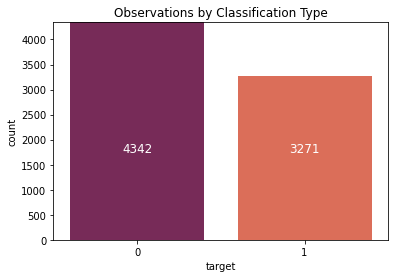

In [81]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart 

# Explore distribution of dataset 
sns.countplot(x = train_data['target'], palette = 'rocket')
ax = plt.gca()
y_max = train_data['target'].value_counts().max() 
ax.set_ylim([0, round(y_max)])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 1700, '%d' % int(p.get_height()), 
            fontsize=12, color='white', ha='center', va= 'bottom')
plt.title("Observations by Classification Type")
plt.show()

## Understanding Duplicate Data

There are 110 tweets in this dataset. When we explored further, we saw that duplicate tweets were not always classified in the same way. As a result, we decided to drop duplicate tweets from the training set to improve our model accuracy.

In [82]:
duplct_cnt = len(train_data['text'])-len(train_data['text'].drop_duplicates())
train_data['duplicate_tweet'] = np.where(train_data['text'].duplicated(keep=False), 1, 0)
print('The most common duplicate tweets are:')
train_data[train_data.duplicate_tweet == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

The most common duplicate tweets are:


,target
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5


In [83]:
dups = train_data[train_data.duplicate_tweet == 1]
print('Duplicate tweets classification:')
dups[['id', 'text', 'target']].sort_values(by='text', ascending=False).head(5)

Duplicate tweets classification:


,id,text,target
5620,8018,wowo--=== 12000 Nigerian refugees repatriated ...,1
5641,8044,wowo--=== 12000 Nigerian refugees repatriated ...,0
6091,8698,that horrible sinking feeling when youÛªve be...,1
6123,8739,that horrible sinking feeling when youÛªve be...,1
6103,8714,that horrible sinking feeling when youÛªve be...,0


## Location Data Considerations:

Much of the location data is not classified consistently and lacks standardization--that is, it contains: 
*   different levels of granularity (countries, states, cities)
*   different versions of the same entity (e.g. United States, USA) 
*   unidentifiable location (e.g. ) 

After attempting to clean the data, we were able to categorize a significant amount of tweets by country, but unfortunately, we were still unable to classify the vast majority of tweets correctly. We considered leveraging the ISO abbreviation which has only two letters, but it leaves a lot of room for error. Since the [majority of Twitter users are based in the US](https://www.statista.com/statistics/242606/number-of-active-twitter-users-in-selected-countries/), state and country abbreviations could easily be confused. As a result, we determined that it would be best not to include location data in our models.

In [84]:
train_data[['location', 'target']].dropna(subset=['location']).groupby('location').count().sort_values(by='target', ascending=False).head(10)

,target
location,
USA,104
New York,71
United States,50
London,45
Canada,29
Nigeria,28
UK,27
"Los Angeles, CA",26
India,24


In [85]:
#CREDIT TO SOURCES
#https://medium.com/swlh/extracting-location-data-from-twitter-54c837144038
#https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb
#https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
#https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column

import geonamescache
from geonamescache.mappers import country

def text_clean(text):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase 
    text = re.sub(r"\d+","",text)   #remove digits and currencies 
    text = re.sub(r'[\$\d+\d+\$]', "", text)      
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks
    return text

#break out location identifiers into separate lists
#US-specific identifiers
city_state_mapping =  pd.read_csv('/Users/benjamin.mok/berkeley/w207/w207-final/data/EDA-data/city_to_state.csv')
US_map = dict(zip(city_state_mapping.city, city_state_mapping.state))
US_cities = set(city_state_mapping.city)
US_states = set(city_state_mapping.state)

#import mapping function
mapper = country(from_key='iso3', to_key='name')
mapper2 = country(from_key='iso', to_key='name')

#country-specific identifiers 
gc = geonamescache.GeonamesCache()  
country_names = gc.get_countries_by_names()
countries = list(country_names.keys())
countries = [c.lower() for c in countries]
iso3 = [val["iso3"].lower() for key, val in country_names.items() if "iso3" in val]

#define dataframe; drop null values 
loc_list = train_data[['location', 'target']].dropna(subset=['location'])
loc_list['location'] = loc_list['location'].apply(lambda x: text_clean(x))

#tokenize the location from each user-generated geo-location (word_tokenize) 
loc_list = loc_list.location.apply(nltk.word_tokenize)

#initialize empty list 
country = []

#categorize by country based on list matches
for location in loc_list:
    l = set(location)

    if l.intersection(countries):
        ctry = list(l.intersection(countries))
        country.append(ctry[0])
        continue

    if l.intersection(US_states):
        country.append('united states')
        continue

    if l.intersection(US_cities):
        country.append('united states')
        continue

    if l.intersection(iso3):
        ctry = list(l.intersection(iso3))
        val = mapper(ctry[0].upper())
        country.append(val.lower())
        continue

    else:
        country.append('unknown')

ldf = loc_list.to_frame()
ldf['country'] = country
ldf['target'] = train_data['target']

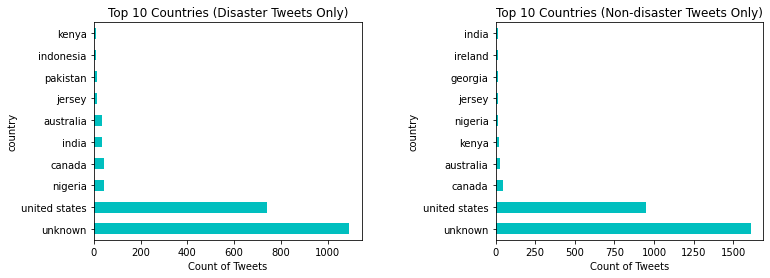

In [86]:
#plot locations by tweet type

disaster_tweets = ldf.loc[ldf['target'] == 1]
dt = disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

non_disaster_tweets = ldf.loc[ldf['target'] == 0]
ndt = non_disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=.5)
dt.plot.barh(ax=ax1, color='c', legend=None)
ndt.plot.barh(ax=ax2, color='c', legend=None)

ax1.set_title('Top 10 Countries (Disaster Tweets Only)')
ax2.set_title('Top 10 Countries (Non-disaster Tweets Only)')
ax1.xaxis.set_label_text('Count of Tweets')
ax2.xaxis.set_label_text('Count of Tweets')
plt.show()

## Top Keywords

To better understand the keyword column in our data, we created word clouds that allowed us to understand which keywords were the most found in disaster vs non-disaster tweets.

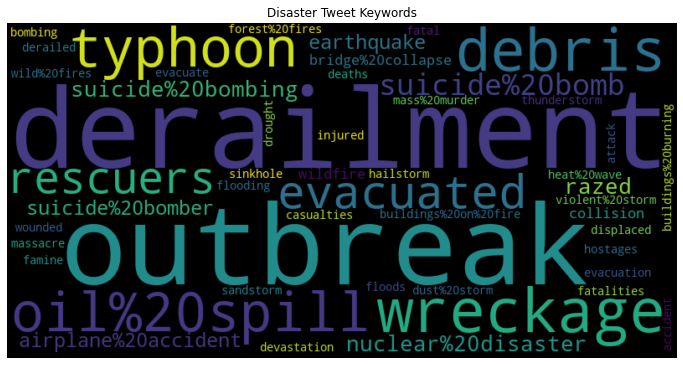

In [87]:
# Code inspired by https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
# Gets us the frequency of words
fdist_0 = FreqDist(train_data[train_data.target == 0 & train_data.keyword.notna()]['keyword'])
fdist_1 = FreqDist(train_data[train_data.target == 1 & train_data.keyword.notna()]['keyword'])

# Generates the WordCloud for disaster tweets
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Disaster Tweet Keywords")
plt.show()

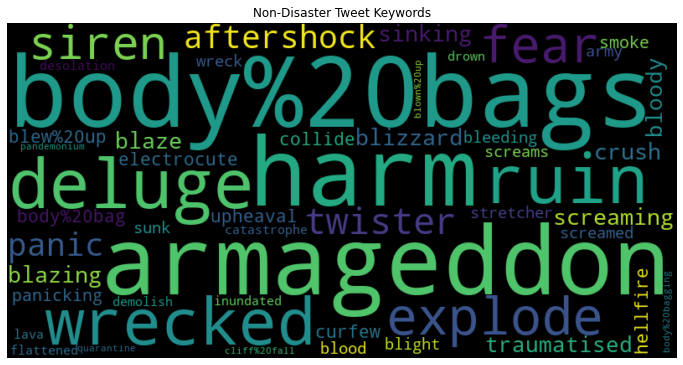

In [88]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_0)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Disaster Tweet Keywords")
plt.show()

We can see that there is a lot of conceptual overlap in the keywords in both the disaster and non-disaster tweets. For instance, note how "body bags" is considered a non-disaster tweet keyword, but seems like it should be a disaster keyword. It seems that all of the keywords could be considered as falling under the disaster realm. Additionally, we are not told how these keywords are generated for the Kaggle competition, which makes us not want to trust them for our modeling. Due to all of these factors, we are leaning towards dropping the keyword field out for our analysis.

## Most Popular Bigrams



When we analyze bigrams, we can see clearer trends which distinguish disaster tweets from non-disaster tweets. Disaster bigrams include top terms such as: "suicide bomber", "oil spill", "california burning" and more. While there are still some confusing bigrams which rise to the top of some non-disaster tweets, like "body bagging" and "burning buildings", terms here seem less associated with public emergencies compared to top terms under disaster tweets.

In [89]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python
#https://stackoverflow.com/questions/43473736/most-common-2-grams-using-python

from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize
# nltk.download('stopwords')

#create dataframe
tweets = train_data[['text', 'target']]

#segment disaster tweets
dt = tweets.loc[tweets['target'] == 1]
dt.columns = ['text', 'target']
dt = dt['text']

#segment non-disaster tweets
ndt = tweets.loc[tweets['target'] == 0]
ndt.columns = ['text', 'target']
ndt = ndt['text']

def count_top_bigrams(tweets):
  #import stop words
    stop_words = set(stopwords.words('english'))

    #clean tweets
    clean_tweets = [word_tokenize(text_clean(tweet)) for tweet in tweets]

    #tokenize tweets and exclude stop words
    token_list = []

    for tweet in clean_tweets:
        tokens = []
        for token in tweet:
            if token not in stop_words:
                tokens.append(token)
                token_list.append(tokens)

  #group tokens as bigrams
    bigram_list = []

    for token in token_list: 
        bigram = list(ngrams(token, 2))
        bigram_list.append(bigram)

  #count bigrams
    cnt = Counter()

    for tweet in bigram_list:
        for bigram in tweet:
            cnt.update(nltk.bigrams(bigram))
    
    top20 = cnt.most_common(20)
    return top20

#store output as dataframes
db = count_top_bigrams(dt)
disaster_bigrams = pd.DataFrame(db, columns=['bigram', 'count'])

ndb = count_top_bigrams(ndt)
non_disaster_bigrams = pd.DataFrame(ndb, columns=['bigram', 'count'])

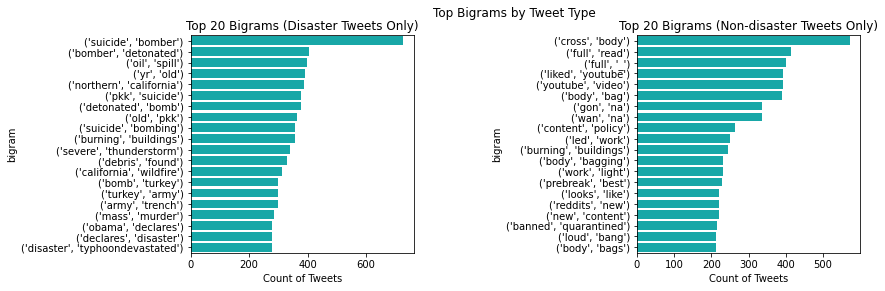

In [90]:
#segment and plot by tweet type

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=1)
fig.suptitle('Top Bigrams by Tweet Type')
sns.barplot(x = disaster_bigrams['count'], y = disaster_bigrams['bigram'], color='c', ax = axes[0])
sns.barplot(x = non_disaster_bigrams['count'], y = non_disaster_bigrams['bigram'], color='c', ax=axes[1])

axes[0].set_title('Top 20 Bigrams (Disaster Tweets Only)')
axes[1].set_title('Top 20 Bigrams (Non-disaster Tweets Only)')
axes[0].xaxis.set_label_text('Count of Tweets')
axes[1].xaxis.set_label_text('Count of Tweets')
plt.show()

## Adding Tweet Metadata as Features

During our initial EDA, we noticed that each tweet had 4 pieces of metadata that we thought could be valuable for our models as additional features. These pieces of metadata were:

1. Hashtags
2. Mentions
3. Retweet
4. Links

We decided to create 3 types of features per piece of metadata, with the exception of Retweet as Retweet can only be represented as a binary feature: 

1. A list of the words that comprise the metadata in the tweet, ex. for links, all of the links within a tweet
2. A binary feature for whether a tweet has an instance of the metadata, ex. for links, whether a tweet has at least one link
3. A numeric feature for the number of instances of metadata the tweet has, ex. for links, the number of links in a tweet

We can create these features using the code below.

In [91]:
### First, let's create all of the regexes that we will need
# The hashtag regex captures all word characters that come after a "#" symbol
hashtag_regex = r'#(\w+)'
# The mention regex captures all word characters that come after an "@" symbol
mention_regex = r'@(\w+)'
# In the data, all links are replaced with links that start with "t.co", for example http://t.co/lHYXEOHY6C
# See https://help.twitter.com/en/using-twitter/url-shortener
# The link regex captures all "t.co" links
link_regex = r'(https?:\/\/t.co/\w+)'
# Retweets are indicated by the symbol "rt", because this is a simple string we don't need to use a heavyweight regex
retweet_indicator = "rt"

### Next, let's create feature 1 per relevant piece of metadata, i.e. a list of the words that comprise the metadata in the tweet
def create_regex_finder_lambda(regex):
    return lambda s: re.findall(regex, s)

train_data['hashtags'] = train_data['text'].apply(create_regex_finder_lambda(hashtag_regex))
train_data['mentions'] = train_data['text'].apply(create_regex_finder_lambda(mention_regex))
train_data['links'] = train_data['text'].apply(create_regex_finder_lambda(link_regex))

### Now let's create feature 2, a binary feature for whether a tweet has an instance of the metadata
retweet_indicator_lambda = lambda s: 1 if retweet_indicator in s.lower().split() else 0
generic_indicator_lambda = lambda s: 0 if len(s) == 0 else 1

train_data['is_retweet'] = train_data['text'].apply(retweet_indicator_lambda)
train_data['has_mentions'] = train_data.mentions.apply(generic_indicator_lambda)
train_data['has_hashtags'] = train_data.hashtags.apply(generic_indicator_lambda)
train_data['has_links'] = train_data.links.apply(generic_indicator_lambda)

### Finally, let's create feature 3, a numeric feature for the number of instances of metadata the tweet has
length_lambda = lambda s: len(s)

train_data['mention_count'] = train_data.mentions.apply(length_lambda)
train_data['hashtag_count'] = train_data.hashtags.apply(length_lambda)
train_data['link_count'] = train_data.links.apply(length_lambda)

# Display data
train_data.head(10)

,id,keyword,location,text,target,duplicate_tweet,hashtags,mentions,links,is_retweet,has_mentions,has_hashtags,has_links,mention_count,hashtag_count,link_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,[earthquake],[],[],0,0,1,0,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,[],[],[],0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,[],[],[],0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,[wildfires],[],[],0,0,1,0,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,"[Alaska, wildfires]",[],[],0,0,1,0,0,2,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,0,"[RockyFire, CAfire, wildfires]",[],[],0,0,1,0,0,3,0
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,0,"[flood, disaster]",[],[],0,0,1,0,0,2,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,0,[],[],[],0,0,0,0,0,0,0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,0,[],[],[],0,0,0,0,0,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,0,[],[],[],0,0,0,0,0,0,0


Now that we have these features, we can perform some EDA to better understand the data represented by these features.

In [92]:
# First, let's define all the functions we will need for our calculations
def get_percentage_with_feature(data, feature):
    return (data[feature].sum()/data.shape[0]) * 100

def get_avg_number_of_feature(data, feature):
    return (data[feature].sum()/data.shape[0])

# Now, let's use these functions to analyze our data
print("Percentage of all training tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(train_data, "has_hashtags")))
print("Percentage of all training tweets with mentions: {:.2f}%".format(get_percentage_with_feature(train_data, "has_mentions")))
print("Percentage of all training tweets with links: {:.2f}%".format(get_percentage_with_feature(train_data, "has_links")))
print("Percentage of all training tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(train_data, "is_retweet")))
print("\n")

disaster_train_data = train_data[train_data.target == 1]
nondisaster_train_data = train_data[train_data.target == 0]

print("Percentage of disaster tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_hashtags")))
print("Percentage of non-disaster tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_hashtags")))

print("Percentage of disaster tweets with mentions: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_mentions")))
print("Percentage of non-disaster tweets with mentions: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_mentions")))

print("Percentage of disaster tweets with links: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_links")))
print("Percentage of non-disaster tweets with links: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_links")))

print("Percentage of disaster tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "is_retweet")))
print("Percentage of non-disaster tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "is_retweet")))
print("\n")

print("Average number of hashtags for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "hashtag_count")))
print("Average number of hashtags for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "hashtag_count")))

print("Average number of mentions for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "mention_count")))
print("Average number of mentions for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "mention_count")))

print("Average number of links for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "link_count")))
print("Average number of links for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "link_count")))
print("\n")

Percentage of all training tweets with hashtags: 22.90%
Percentage of all training tweets with mentions: 26.39%
Percentage of all training tweets with links: 52.15%
Percentage of all training tweets that are retweets: 1.06%


Percentage of disaster tweets with hashtags: 26.23%
Percentage of non-disaster tweets with hashtags: 20.38%
Percentage of disaster tweets with mentions: 20.36%
Percentage of non-disaster tweets with mentions: 30.93%
Percentage of disaster tweets with links: 66.37%
Percentage of non-disaster tweets with links: 41.43%
Percentage of disaster tweets that are retweets: 1.22%
Percentage of non-disaster tweets that are retweets: 0.94%


Average number of hashtags for disaster tweets: 0.50
Average number of hashtags for non-disaster tweets: 0.39
Average number of mentions for disaster tweets: 0.27
Average number of mentions for non-disaster tweets: 0.42
Average number of links for disaster tweets: 0.77
Average number of links for non-disaster tweets: 0.51




From this initial EDA, we can see that there is a difference between disaster tweets and non-disaster tweets in terms of having links, mentions, and hashtags, with a marked difference for links in particular, leading us to believe that these features could provide value for us in modeling.

To complete the EDA on these metadata features, we will also create plots to better understand the distributions of the feature count columns.

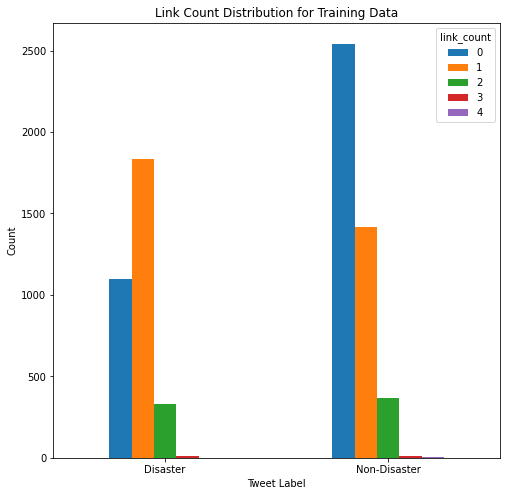

In [93]:
def create_bar_plot(column, title):
    df = train_data.copy(deep=True)
    df['target'].replace({0: "Non-Disaster", 1: "Disaster"}, inplace=True)
    df.pivot_table(index='target', columns=column, aggfunc='size').plot(kind='bar', figsize=(8, 8), rot=0, title=title, xlabel="Tweet Label", ylabel="Count")
    plt.show()
    
create_bar_plot('link_count', 'Link Count Distribution for Training Data')

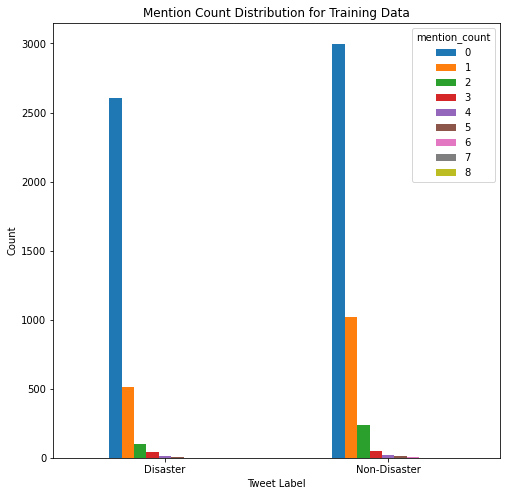

In [94]:
create_bar_plot('mention_count', 'Mention Count Distribution for Training Data')

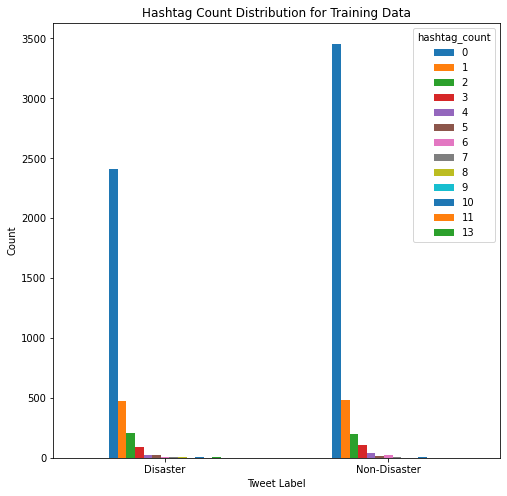

In [95]:
create_bar_plot('hashtag_count', 'Hashtag Count Distribution for Training Data')

From these plots above, we can see that there are differences in the distributions for our three count features, with a marked difference again in the link count that mirrors the difference in the binary feature for links that we saw in our earlier data analysis. With this EDA, it does appear that these metadata features, especially the link features, could add value to our models.

# Data Cleanup

### Setting Up Data for Modeling

To ensure that we are ready for modeling, we are going to split our train data into data and labels, set up a cross-validation procedure, and load in our test data. We want to set up cross-validation (CV) for our model, since we don't have all that much training data and also want to avoid overfitting. To do this, we will set up a CV function here that we can use both for GridSearchCV hyperparameter tuning and model evaluation.

In [96]:
# Dropping all duplicate tweets based off of results of EDA
train_data = train_data.drop_duplicates(subset=['text'], keep='first')

# Creating numpy arrays for labels and tweets for modeling
train_labels = np.array(train_data['target'])
train_text = np.array(train_data['text'])

# Dropping the label column from the train data
train_data.drop(columns=["target"])

# See more information about parameters here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# "n_splits" splits our data into 10 training/validation sets
# "shuffle" shuffles the data before splitting into batches, "random_state" allows for reproducability across function calls
cv = KFold(n_splits=10, random_state=1, shuffle=True)

## Text Preprocessing

In text classification problems, text pre-processing is a crucial part to prepping our data for analysis. This can be found in our preprocess() function (below). Some pre-processing considerations we have made include:
* removing numbers, symbols, and punctuation
    * We have split the @ and # symbols from the following text as another feature in our feature vector(s)
* standardizing to lowercase text
* remove stop words
* word stemming
* trailing spaces
* Lemmatize: (study -> study, studies -> study)
* Stemmatize: (study -> study, studies -> studi)

In [97]:
def preprocess(text, method=None, tokenizer=sent_tokenize, rm_stop=False): 
    """Returns a text processed string.

    Arguments:
    text      -- String, func is designed for loops
    
    method    -- ('s','l') Specify from s - stemmatize, l - lemmatize.
                 None will mean you do not want to remove suffix.
                 
    tokenizer -- Any tokenizer function, from word to sentence to tweet.
                 Tokenizer must not be an object.method unless you
                 specifiy it to be like TweetTokenizer.tokenize.
                 Sentence tokenizer is initialized here.
                 
    rm_stop   -- Bool. Remove stop words or not.
    """
    
    #remove line breaks
    text = re.sub(r"\n","",text)
    
    #remove trailing spaces
    text = re.sub(r'[ \t]+$','', text)
    
    #convert to lowercase 
    text = text.lower()
    
    #remove digits and currencies 
    text = re.sub(r"\d+","",text) 
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    
    #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    
    #remove non-ascii
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 

    text = re.sub(link_regex, "http://t.co", text)
    # separate out mention symbol from text so that models can learn from number of mentions
    p = re.compile(mention_regex)
    text = p.sub(r'@ \1',text)

    # separate out hashtag symbol from hashtag so that models can learn from number of hashtags
    q = re.compile(hashtag_regex)
    text = q.sub(r'# \1',text)
    
    # remove retweet indicator text as it's rarely used
    text = re.sub(retweet_indicator, "", text)
    
    if rm_stop:
        filtered_tokens = [word for word in tokenizer(text) 
                           if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    if method == 'l':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) 
                       for word in tokenizer(text)]
        return " ".join(lemm_tokens)
    
    elif method == 's':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) 
                       for word in tokenizer(text)]
        return " ".join(stem_tokens)
    return text

In [98]:
def run_model_on_preprocessed_text(preprocessed_text):
    tfidf = TfidfVectorizer()
    transformed_data = tfidf.fit_transform(preprocessed_text)
    model = MultinomialNB(alpha=0.9) # Best alpha from project 3
    accuracy_scores = cross_val_score(model, transformed_data, train_labels, scoring='accuracy', cv=cv)
    f1_scores = cross_val_score(model, transformed_data, train_labels, scoring='f1', cv=cv)
    print('Accuracy: %.3f (%.3f)' % (mean(accuracy_scores), std(accuracy_scores)))
    print('F1 Scores: %.3f (%.3f)' % (mean(f1_scores), std(f1_scores)))

def preprocess_text():
    return [preprocess(i) for i in train_data.text]
    
def preprocess_text_with_additional_cleaning(tokenizer):
    return [preprocess(i,method='l',tokenizer=tokenizer,rm_stop=True) for i in train_data.text]

print('Score on no SW removal, no suffix striping and TFIDF:')
run_model_on_preprocessed_text(preprocess_text())
print('Test on Lemmatize, remove stop and CountVectorize:')
run_model_on_preprocessed_text(preprocess_text_with_additional_cleaning(word_tokenize))

Score on no SW removal, no suffix striping and TFIDF:
Accuracy: 0.802 (0.012)
F1 Scores: 0.737 (0.018)
Test on Lemmatize, remove stop and CountVectorize:
Accuracy: 0.805 (0.014)
F1 Scores: 0.748 (0.020)


## Generic Code for Model Creation

To standardize our model development, we decided to create some helper functions and variables that can be used across different model types. We will create functions that allow us to transform data using different vectorizers (both Count and TFIDF), fitting a provided model using GridSearch using 10-fold cross-validation to find the best combination of hyperparameters per model, and running provided models on transformed data using both accuracy and f1 for scoring. We also will create preprocessed text using the cleaning functions defined previously so that we don't have to recompute this per model. For data with extra cleaning, stop words are removed and lemmatization is applied.

For each of the models we evaluate, we will use the following different combinations of data that we discussed before:

1. TFIDF transformed scaled data without additional cleaning
2. Count Vectorizer transformed scaled data without additional cleaning
3. TFIDF transformed scaled data with additional cleaning
4. Count Vectorizer transformed scaled data with additional cleaning

In [99]:
def run_model_on_transformed_data(model, transformed_data, params):
    print("Fitting GridSearch to optimize accuracy (this takes a while)...")
    accuracy_gridsearch_model = fit_gridsearch_model(model, transformed_data, params, 'accuracy')
    print("Fitting GridSearch to optimize f1 score (this takes a while)...")
    f1_gridsearch_model = fit_gridsearch_model(model, transformed_data, params, 'f1')

    print('Best params for accuracy: ', accuracy_gridsearch_model.best_params_)
    print('Best mean score for accuracy: {:.2%}'.format(accuracy_gridsearch_model.best_score_))

    print('Best params for f1: ', f1_gridsearch_model.best_params_)
    print('Best mean score for f1: {:.2%}'.format(f1_gridsearch_model.best_score_))
    
def fit_gridsearch_model(model, data, params, scoring):
    gridsearch_model = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1, verbose=3)
    return gridsearch_model.fit(data, train_labels)

def transform_data_with_count_vectorizer(preprocessed_text):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(preprocessed_text)
       
def transform_data_with_tfidf(preprocessed_text):
    tfidf = TfidfVectorizer()
    return tfidf.fit_transform(preprocessed_text)

preprocessed_text = preprocess_text()
preprocessed_text_with_additional_cleaning = preprocess_text_with_additional_cleaning(word_tokenize)

tfidf_transformed = transform_data_with_tfidf(preprocessed_text)
count_vectorizer_transformed = transform_data_with_count_vectorizer(preprocessed_text)

tfidf_transformed_cleaned = transform_data_with_tfidf(preprocessed_text_with_additional_cleaning)
count_vectorizer_transformed_cleaned = transform_data_with_count_vectorizer(preprocessed_text_with_additional_cleaning)

### After the data has been cleaned and text pre-processed, we can begin exploring different algorithms. The four machine learning algorithms we will focus on are:
To see how effective our model selection process was going to be, we decided to create a set of baseline models in order to compare the accuracies of our _improve_
* Naive Bayes             - 76.13%
* Logistic Regression     - 76.80%
* Support Vector Machines - 77.93%
* K-Nearest Neighbors     - 65.67%

In [100]:
np.random.seed(1)
prelim_models = [MultinomialNB(), LogisticRegression(), svm.SVC(), KNeighborsClassifier()]
countvec            = CountVectorizer()
prelim_train  = countvec.fit_transform(train_data.text)

prelim_train_text, prelim_train_labels   = prelim_train[int(len(train_data.text)/5):], train_data.target[int(len(train_data.text)/5):] 
dev_text  , dev_labels     = prelim_train[:int(len(train_data.text)/5)], train_data.target[:int(len(train_data.text)/5)]

for i in prelim_models:
    #if 'MultinomialNB' in str(type(i)):
    i.fit(prelim_train_text, prelim_train_labels)
    dev_pred = i.predict(dev_text)
    accuracy = metrics.accuracy_score(dev_pred, dev_labels)
    print('Model {} had a baseline accuracy of {:.2f}%'.format(i, accuracy*100))
    print()

Model MultinomialNB() had a baseline accuracy of 76.13%



/Users/benjamin.mok/berkeley/w207/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model LogisticRegression() had a baseline accuracy of 76.80%

Model SVC() had a baseline accuracy of 77.93%

Model KNeighborsClassifier() had a baseline accuracy of 65.67%



## Naive Bayes Model Optimization

Naive Bayes models are among the most simple and efficient models available when exploring a classification problem. Despite their simplicity, these probabilistic classifiers can acheive excellent results when applied to complex learning problem. In addition, these models work very well for text classification as they have a strong independence assumption and can handle high dimensionality.

The Multinomial Naive Bayes model is a natural fit for this particular project, as it deals with the frequency of events (i.e. word count). However, even in the case where we use Tfidf vectorization the model is still service-able, and achieves competitive accuracies and sensitivities even compared to much more complex models.

We tested our Multinomial Naive Bayes model with varying degrees of pre-processing and vectorization. In addition we varied the alpha parameter of the model, which corresponds to the degree of regularization (in Naive Bayes, the term used is "smoothing").  We achieved our highest accuracy (80.47%) and f1 score (74.71%) with a Tf-idf Vectorization and extra text cleaning and an alpha of 1.

In [101]:
#Define parameters for optimization
params = {
    'alpha': [.01, .1, 1, 10]
}

#Define model
model = MultinomialNB()

print('No SW removal, no suffix striping, TFIDF:')
run_model_on_transformed_data(model, tfidf_transformed, params)
print('\n')

print('No SW removal, no suffix striping, CountVectorize:')
run_model_on_transformed_data(model, count_vectorizer_transformed, params)
print('\n')

print('Lemmatize, remove stop words, TFIDF:')
run_model_on_transformed_data(model, tfidf_transformed_cleaned, params)
print('\n')

print('Lemmatize, remove stop words, CountVectorize:')
run_model_on_transformed_data(model, count_vectorizer_transformed_cleaned, params)
print('\n')

No SW removal, no suffix striping, TFIDF:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params for accuracy:  {'alpha': 1}
Best mean score for accuracy: 80.17%
Best params for f1:  {'alpha': 0.1}
Best mean score for f1: 75.02%


No SW removal, no suffix striping, CountVectorize:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params for accuracy:  {'alpha': 1}
Best mean score for accuracy: 79.97%
Best params for f1:  {'alpha': 1}
Best mean score for f1: 75.71%


Lemmatize, remove stop words, TFIDF:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds

## Logistic Regression Model Optimization



We decided to test logistic regression as a binary classification problems are ideal use cases for this classifier. Logistic regression algorithm can also utilize the additional features that we created from the tweet text (i.e. 'is_retweet', 'has_mentions', 'has_links'). This classifer uses a weighted combination of the input features and passes them through a sigmoid function. The sigmoid function then allows it to classify the tweet as either a disaster or non-disaster tweet using the values, 1 and 0.

The best result that we were able to yield with this model was through the use of TfidfVectorizer, stop word removal, and suffix striping. This combination yielded an F1 score of 75.4% (with a C = 10) and an accuracy score of 80.46% (with C = 10).

In [102]:
#CREDIT TO SOURCES: 
#https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
#https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
#https://towardsdatascience.com/natural-language-processing-on-multiple-columns-in-python-554043e05308

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#vectorize data 
vectorizer = CountVectorizer()
vtrain = vectorizer.fit_transform(preprocessed_text)
text_train = pd.DataFrame(vtrain.todense(), columns = vectorizer.get_feature_names())

addl_vtrain = vectorizer.fit_transform(preprocessed_text_with_additional_cleaning)
addl_text_train = pd.DataFrame(addl_vtrain.todense(), columns = vectorizer.get_feature_names())

#generate TfidfVectorizer data
tfid_vectorizer = TfidfVectorizer()
t_train = tfid_vectorizer.fit_transform(preprocessed_text)
tfid_text_train = pd.DataFrame(t_train.todense(), columns = tfid_vectorizer.get_feature_names())

addl_ttrain = tfid_vectorizer.fit_transform(preprocessed_text_with_additional_cleaning)
addl_tfid_text_train = pd.DataFrame(addl_ttrain.todense(), columns = tfid_vectorizer.get_feature_names())

#determine additional features to include in model 
features = ['is_retweet', 'has_mentions', 'has_links']
features_train = train_data[features]

#use hstack to combine CountVectorizer and addl feature data 
train = np.hstack((features_train, text_train))
train_v2 = np.hstack((features_train, addl_text_train))

#use hstack to combine TfidfVectorizer and addl feature data 
tfid_train = np.hstack((features_train, tfid_text_train))
tfid_train_v2 = np.hstack((features_train, addl_tfid_text_train))

model = LogisticRegression()
params = {
    'C': [0.001,0.01,0.1, 0.5, 1,10,100],
    'solver': ['liblinear'],
    'multi_class': ['auto'],
}

print('No SW removal, no suffix striping, CountVectorize:')
run_model_on_transformed_data(model, train, params)
print('\n')

print('Lemmatize, remove stop words, CountVectorize:')
run_model_on_transformed_data(model, train_v2, params)
print('\n')

print('No SW removal, no suffix striping, TFIDF:')
run_model_on_transformed_data(model, tfid_train, params)
print('\n')

print('Lemmatize, remove stop words, TFIDF:')
run_model_on_transformed_data(model, tfid_train_v2, params)
print('\n')

/Users/benjamin.mok/berkeley/w207/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No SW removal, no suffix striping, CountVectorize:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best params for accuracy:  {'C': 0.5, 'multi_class': 'auto', 'solver': 'liblinear'}
Best mean score for accuracy: 80.41%
Best params for f1:  {'C': 0.5, 'multi_class': 'auto', 'solver': 'liblinear'}
Best mean score for f1: 75.33%


Lemmatize, remove stop words, CountVectorize:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best params for accuracy:  {'C': 0.5, 'multi_class': 'auto', 'solver': 'liblinear'}
Best mean score for accuracy: 80.25%
Best params for f1:  {'C': 1, 'multi_class': 'auto

## SVM Model Optimization

For our third model type, we decided to fit an SVM. Although SVMs can use multiple kernels, we decided to use a linear kernel for several reasons:

1. Linear kernels are good for data with lots of features, like text data
2. Most text categorization problems are linearly separable
3. Linear kernels train faster than other kernel types, which is good since we are using 10-fold cross-validation, which creates `10 * (# of parameters)` models to fit using GridSearch, and we are running on limited compute capacity

See http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf for more details on 1 and 2 above.

To speed up the training of the SVM, we scaled the data. We had several options for scaling, but ended up using the MaxAbsScaler, which according to the SKLearn docs, "scales in a way that the training data lies within the range [-1, 1] by dividing through the largest maximum value in each feature. It is meant for data that is already centered at zero or sparse data." (See https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing). Since our data is sparse, we decided that this would be the best scaler for our use case.

In [103]:
# Function to scale data to speed up SVM fitting
def scale_data(vectorized_text):
    return preprocessing.MaxAbsScaler().fit_transform(vectorized_text)

params = {
    'C': [.01, .1, .5, 1],
    'kernel': ['linear'],
}

model = svm.SVC(random_state=1)

print('No SW removal, no suffix striping, TFIDF:')
run_model_on_transformed_data(model, scale_data(tfidf_transformed), params)
print('\n')

print('No SW removal, no suffix striping, CountVectorize:')
run_model_on_transformed_data(model, scale_data(count_vectorizer_transformed), params)
print('\n')

print('Lemmatize, remove stop words, TFIDF:')
run_model_on_transformed_data(model, scale_data(tfidf_transformed_cleaned), params)
print('\n')

print('Lemmatize, remove stop words, CountVectorize:')
run_model_on_transformed_data(model, scale_data(count_vectorizer_transformed_cleaned), params)
print('\n')

No SW removal, no suffix striping, TFIDF:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params for accuracy:  {'C': 0.1, 'kernel': 'linear'}
Best mean score for accuracy: 80.38%
Best params for f1:  {'C': 0.5, 'kernel': 'linear'}
Best mean score for f1: 74.21%


No SW removal, no suffix striping, CountVectorize:
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params for accuracy:  {'C': 0.1, 'kernel': 'linear'}
Best mean score for accuracy: 80.17%
Best params for f1:  {'C': 0.1, 'kernel': 'linear'}
Best mean score for f1: 73.67%


Lemmatize, remove stop words, TFIDF:
Fitting Gr

From the output above, we can see that the model with the highest f1 and accuracy scores is model 1, the TFIDF transformed scaled data without additional cleaning, with an accuracy score of 80.38% and an f1 score of 74.21%. 

## KNN Model Optimization

The final method we decided to use as a tweet classifier was the K-Nearest Neighbors classifier. Prior to this, we have never heard of using KNN as a classifier for text, so we thought it would be very interesting to see how well the KNN classifier would perform. Similar to the framework of the previous modeling, we ran this through a k-fold cross validation to see which KNN parameters would fare the best for each method of text pre-processing.

It is important to note here that the KNN classifier is famously slow for many observations, the algorithms used here are auto and brute force, however, the tree algorithms that are available in the KNN module cannot be used due to the sparse data we are passing into the model. We have explored using singular value decomposition (SVD) to turn our sparse data into dense data to use the tree algorithms, but we found that doing so did not make too much of a difference. This is because we have a relatively small set of data allowing brute-force to not be computationally taxing. So it is obvious that the best algorithm for all four cases are 'auto'.

In [104]:
def svd_for(vectorized_text):
    svd = TruncatedSVD()
    return svd.fit_transform(vectorized_text)

# Recreating the fit_gridsearch_model(...) here because 
# a verbose=3 parameter printed out too much redundant 
# jargon (10000+ lines)
def fit_gridsearch_model(model, data, params, scoring):
    gridsearch_model = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    return gridsearch_model.fit(data, train_labels)

knn    = KNeighborsClassifier()
params = {
            'n_neighbors' : [3, 6, 9, 12],
            #'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'algorithm' : ['auto','brute'],
            'metric' : ['euclidean','manhattan','minkowski']
        }

print('\nKNN Model Count Vectorizer (w/ stop word removal):')
run_model_on_transformed_data(knn, count_vectorizer_transformed, params)
print('\nKNN Model TFIDF (w/ stop word removal):')
run_model_on_transformed_data(knn, tfidf_transformed, params)
print('\nKNN Model Vectorizer (lemmatize and stop word removal):')
run_model_on_transformed_data(knn, count_vectorizer_transformed_cleaned, params)
print('\nKNN Model TFIDF with extra cleaning (lemmatize and stop word removal):')
run_model_on_transformed_data(knn, tfidf_transformed_cleaned, params)



KNN Model Count Vectorizer (w/ stop word removal):
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best params for accuracy:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best mean score for accuracy: 69.29%
Best params for f1:  {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3}
Best mean score for f1: 48.55%

KNN Model TFIDF (w/ stop word removal):
Fitting GridSearch to optimize accuracy (this takes a while)...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting GridSearch to optimize f1 score (this takes a while)...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best params for accuracy:  {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 12}
Best mean score for accuracy: 78.18%
Best params for f1:  {'algori

[CV 7/10] END .......................alpha=0.01;, score=0.765 total time=   0.0s
[CV 10/10] END .......................alpha=0.1;, score=0.800 total time=   0.0s
[CV 9/10] END ..........................alpha=1;, score=0.793 total time=   0.0s
[CV 2/10] END .........................alpha=10;, score=0.743 total time=   0.0s
[CV 5/10] END .......................alpha=0.01;, score=0.743 total time=   0.0s
[CV 9/10] END .......................alpha=0.01;, score=0.723 total time=   0.0s
[CV 3/10] END ........................alpha=0.1;, score=0.766 total time=   0.0s
[CV 6/10] END ........................alpha=0.1;, score=0.745 total time=   0.0s
[CV 9/10] END ........................alpha=0.1;, score=0.737 total time=   0.0s
[CV 2/10] END ..........................alpha=1;, score=0.769 total time=   0.0s
[CV 5/10] END ..........................alpha=1;, score=0.738 total time=   0.0s
[CV 8/10] END ..........................alpha=1;, score=0.703 total time=   0.0s
[CV 1/10] END ..............

[CV 5/10] END .......................alpha=0.01;, score=0.792 total time=   0.0s
[CV 5/10] END ........................alpha=0.1;, score=0.803 total time=   0.0s
[CV 9/10] END ........................alpha=0.1;, score=0.787 total time=   0.0s
[CV 2/10] END ..........................alpha=1;, score=0.823 total time=   0.0s
[CV 5/10] END ..........................alpha=1;, score=0.805 total time=   0.0s
[CV 8/10] END ..........................alpha=1;, score=0.780 total time=   0.0s
[CV 1/10] END .........................alpha=10;, score=0.760 total time=   0.0s
[CV 8/10] END .......................alpha=0.01;, score=0.707 total time=   0.0s
[CV 9/10] END .........................alpha=10;, score=0.783 total time=   0.0s
[CV 3/10] END .......................alpha=0.01;, score=0.750 total time=   0.0s
[CV 6/10] END .......................alpha=0.01;, score=0.732 total time=   0.0s
[CV 9/10] END .......................alpha=0.01;, score=0.726 total time=   0.0s
[CV 2/10] END ..............

[CV 3/10] END .......................alpha=0.01;, score=0.807 total time=   0.0s
[CV 4/10] END ........................alpha=0.1;, score=0.793 total time=   0.0s
[CV 8/10] END ........................alpha=0.1;, score=0.772 total time=   0.0s
[CV 1/10] END ..........................alpha=1;, score=0.814 total time=   0.0s
[CV 7/10] END ..........................alpha=1;, score=0.788 total time=   0.0s
[CV 5/10] END .........................alpha=10;, score=0.733 total time=   0.0s
[CV 1/10] END .......................alpha=0.01;, score=0.725 total time=   0.0s
[CV 3/10] END .......................alpha=0.01;, score=0.758 total time=   0.0s
[CV 6/10] END .......................alpha=0.01;, score=0.725 total time=   0.0s
[CV 1/10] END ........................alpha=0.1;, score=0.757 total time=   0.0s
[CV 2/10] END .......................alpha=0.01;, score=0.790 total time=   0.0s
[CV 5/10] END .......................alpha=0.01;, score=0.767 total time=   0.0s
[CV 8/10] END ..............

[CV 1/10] END .......................alpha=0.01;, score=0.774 total time=   0.0s
[CV 3/10] END ..........................alpha=1;, score=0.802 total time=   0.0s
[CV 6/10] END ..........................alpha=1;, score=0.807 total time=   0.0s
[CV 4/10] END .........................alpha=10;, score=0.748 total time=   0.0s
[CV 7/10] END .........................alpha=10;, score=0.739 total time=   0.0s
[CV 10/10] END ........................alpha=10;, score=0.739 total time=   0.0s
[CV 8/10] END .......................alpha=0.01;, score=0.751 total time=   0.0s
[CV 1/10] END ........................alpha=0.1;, score=0.792 total time=   0.0s
[CV 8/10] END .........................alpha=10;, score=0.707 total time=   0.0s
[CV 1/10] END .......................alpha=0.01;, score=0.771 total time=   0.0s
[CV 4/10] END .......................alpha=0.01;, score=0.760 total time=   0.0s
[CV 7/10] END .......................alpha=0.01;, score=0.755 total time=   0.0s
[CV 10/10] END .............

[CV 6/10] END .......................alpha=0.01;, score=0.780 total time=   0.0s
[CV 6/10] END ........................alpha=0.1;, score=0.796 total time=   0.0s
[CV 9/10] END ..........................alpha=1;, score=0.788 total time=   0.0s
[CV 7/10] END .......................alpha=0.01;, score=0.751 total time=   0.0s
[CV 1/10] END ........................alpha=0.1;, score=0.802 total time=   0.0s
[CV 4/10] END ........................alpha=0.1;, score=0.783 total time=   0.0s
[CV 8/10] END ........................alpha=0.1;, score=0.760 total time=   0.0s
[CV 7/10] END ..........................alpha=1;, score=0.779 total time=   0.0s
[CV 1/10] END .........................alpha=10;, score=0.818 total time=   0.0s
[CV 5/10] END .........................alpha=10;, score=0.791 total time=   0.0s
[CV 9/10] END .........................alpha=10;, score=0.797 total time=   0.0s
[CV 3/10] END .......................alpha=0.01;, score=0.757 total time=   0.0s
[CV 5/10] END ..............

From the output of the kfold cross validations and the different data cleaning methods listed above above, it seems like the TFIDF with stop words removed data for KNN model with parameters: euclidean distance, and 12 nearest neighbors had the highest accuracy of 78.18% and while a KNN model with 9 nearest neighbors had the highest f1_score of 72.03%. We did not expect the KNN model to perform as well relative to the other models we created, so this is very interesting to us.

Note that it is safe to assume that the higher number of neighbors we use, the higher the accuracy and f1_scores would be, however they would be increasing at logarithmically diminishing rates and with a higher compute time. 



## Conclusion

Through thorough consideration and discussion, our group decided to move forward with _accuracy_ as our primary model evaluation criteria. This is due to the fact that an accuracy measurement is better suited for classifiers that weigh heavier on true positive and true negative classifications, which in our case works better for classifying between disaster vs. non-disaster tweets. F1 score weighs heavier on false negative and false positive classifications.

To recall our __baseline accuracy__ measurements:
* Naive Bayes             - 76.13%
* Logistic Regression     - 76.80%
* Support Vector Machines - 77.93%
* K-Nearest Neighbors     - 65.67%

After hyper-parameter tuning and using different methods of text pre-processing the __accuracy__ of our algorithms that performed best to worst are as follows:
* Naive Bayes - 80.47%
* Logistic Regression - 80.46%
* Support Vector Machines - 80.38%
* K-Nearest Neighbor - 78.18%

The results of the top three algorithms we chose all came in relatively closely, after some optimization. Despite hypothesizing the KNN method would not perform as well, it actually yielded results better than expected.

Additionally, we generally see higher accuracies and better training results with tf-idf vectorization, rather than a simple count vectorizerization. Overall, all models' accuracies improved compared to baseline performances, with KNN improving the most.